# Anomalies in Time Series Data

# *From the curriculum*

## Pointers: 

- Target variable is continuous

- We're trying to detect anomalies by seeing data over a timeframe and noticing any spikes in distributions

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('https://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [3]:
df_orig

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""
...,...,...,...,...,...,...,...
13969,97.105.19.58,[17/Apr/2019:12:55:12 +0000],"""GET /api/v1/sales?page=62 HTTP/1.1""",200,511544,NaN,"""python-requests/2.21.0"""
13970,97.105.19.58,[17/Apr/2019:12:55:12 +0000],"""GET /api/v1/sales?page=65 HTTP/1.1""",200,511201,NaN,"""python-requests/2.21.0"""
13971,97.105.19.58,[17/Apr/2019:12:55:13 +0000],"""GET /api/v1/sales?page=73 HTTP/1.1""",200,511781,NaN,"""python-requests/2.21.0"""
13972,97.105.19.58,[17/Apr/2019:12:55:13 +0000],"""GET /api/v1/sales?page=69 HTTP/1.1""",200,510136,NaN,"""python-requests/2.21.0"""


In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 7 columns):
ip                13974 non-null object
timestamp         13974 non-null object
request_method    13974 non-null object
status            13974 non-null int64
size              13974 non-null int64
destination       25 non-null object
request_agent     13974 non-null object
dtypes: int64(2), object(5)
memory usage: 764.3+ KB


**Below (vv) are fabricated anomalies for our detection.**

In [5]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [6]:
df

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""
...,...,...,...,...,...,...,...
13973,97.105.19.58,[17/Apr/2019:12:55:14 +0000],"""GET /api/v1/sales?page=71 HTTP/1.1""",200,510166,NaN,"""python-requests/2.21.0"""
0,95.31.18.119,[21/Apr/2019:10:02:41+0000],GET /api/v1/items/HTTP/1.1,200,1153005,NaN,python-requests/2.21.0
1,95.31.16.121,[17/Apr/2019:19:36:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0
2,97.105.15.120,[18/Apr/2019:19:42:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,301,2560,NaN,python-requests/2.21.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


## Takeaways from ^^:

1.) timestamp - remove square brackets, replace the first colon (after dd/MM/yyyy) with a space so that we can then convert to datetime dtype, convert to datetime, and set is as index.

In [8]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [9]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


### Cleanup Strings

- Remove quotation marks and '?page=x' from request_method.

- Remove quotation marks from request_agent.

In [10]:
df.destination.value_counts()

"https://python.zach.lol/"                                        4
"https://ds.codeup.com/8.3_Acquire/"                              3
"https://python.zach.lol/api/v1/"                                 2
"https://python.zach.lol/api/v1/stores?page=1"                    2
"https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!"                1
"https://python.zach.lol/api/v1/stores?page=999"                  1
"https://python.zach.lol/api/V1/HiZach!"                          1
"https://python.zach.lol/api/v1//api/v1/items/next_page"          1
"https://python.zach.lol/api/v1/items"                            1
"https://python.zach.lol/api/v1/stores?page=0"                    1
"https://python.zach.lol/api/v1/helloclass!"                      1
"https://python.zach.lol/api/v1//api/v1/items?page=2"             1
"https://python.zach.lol/api/v1/items?page=0"                     1
"http://localhost:8889/notebooks/timeseries_acquisition.ipynb"    1
"https://python.zach.lol/api/v1//api/v1/items"  

In [11]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [12]:
len(df.request_method.value_counts())

220

In [13]:
df.request_method.value_counts()

GET /api/v1/sales?page=2 HTTP/1.1       709
GET /api/v1/items HTTP/1.1              464
GET /api/v1/items?page=2 HTTP/1.1       291
GET /api/v1/items?page=3 HTTP/1.1       219
GET /api/v1/stores HTTP/1.1             162
                                       ... 
GET /api/v1/helloclass! HTTP/1.1          1
GET /api/v1/items&page=0 HTTP/1.1         1
GET /api/v1/items?page=4 HTTP/1.1         1
GET /api/v1/stores?page=999 HTTP/1.1      1
GET /api/v1/stores?page=666 HTTP/1.1      1
Name: request_method, Length: 220, dtype: int64

In [14]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex = True)

In [15]:
len(df.request_method.value_counts())

22

In [16]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/v1//api/v1/items/next_page HTTP/1.1        1
GET /api/v1 HTTP/1.1                                1
GET /api/v1/items&page=0 HTT

In [17]:
df[['request_call','api_version','endpoints','http']] = \
    df.request_method.str.extract(r'(?P<request_call>^[A-Z]+)\s(?P<api_version>\/api\/v[0-9])(?P<endpoints>.+)(?P<http_version>HTTP\/[0-9]\.[0-9])', expand = True)

In [18]:
df.head()

,ip,request_method,status,size,destination,request_agent,request_call,api_version,endpoints,http
timestamp,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,GET,/api/v1,/items,HTTP/1.1
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1


In [19]:
# replace '/HTTP' with ', HTTP'

print(df.endpoints.value_counts())

/sales                       12403
/items                        1065
/stores                        229
//api/v1/items                  11
/items/api/v1/items              7
/items/next_page                 5
/                                4
/itemsitems                      3
/sales/                          3
/sales/                          3
/store                           3
items                            2
//api/v1/items/next_page         1
/items/                          1
/items&page=0                    1
/helloclass!                     1
                                 1
/I_DIDNT_DO_IT!!!!               1
Name: endpoints, dtype: int64


In [20]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [21]:
compute_entropy(df.api_version)

0

In [22]:
compute_entropy(df.status)

0.0103058384931202

In [23]:
compute_entropy(df.request_call)

0

In [24]:
compute_entropy(df.ip)

0.5669620287409953

In [25]:
## Change sizes to MB (or GB) for easier understanding:


df['size_mb'] = [n/1024/1024 for n in df['size']]

In [26]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


1.) Resample to 30 minute intervals taking max of size.

2.) Fill in missing datetimestamps (those not present because no data was captured during that time. We want to have continuous time and those time periods filled with 0).

In [27]:

my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_size = df['size_mb'].resample('30T').max()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

In [28]:
df.head()

2019-04-16 19:30:00+00:00    0.489937
2019-04-16 20:00:00+00:00    0.489937
2019-04-16 20:30:00+00:00    0.489937
2019-04-16 21:00:00+00:00    0.489937
2019-04-16 21:30:00+00:00    0.489937
Freq: 30T, Name: size_mb, dtype: float64

# Simple Moving Average:

In [29]:
# Calculating the short-window simple moving average
short_rolling = df.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = df.rolling(window=24).mean()

In [30]:
short_rolling.head(13)

2019-04-16 19:30:00+00:00         NaN
2019-04-16 20:00:00+00:00         NaN
2019-04-16 20:30:00+00:00         NaN
2019-04-16 21:00:00+00:00         NaN
2019-04-16 21:30:00+00:00         NaN
2019-04-16 22:00:00+00:00         NaN
2019-04-16 22:30:00+00:00         NaN
2019-04-16 23:00:00+00:00         NaN
2019-04-16 23:30:00+00:00         NaN
2019-04-17 00:00:00+00:00         NaN
2019-04-17 00:30:00+00:00         NaN
2019-04-17 01:00:00+00:00    0.286391
2019-04-17 01:30:00+00:00    0.286391
Freq: 30T, Name: size_mb, dtype: float64

In [31]:
short_rolling[20:30]

2019-04-17 05:30:00+00:00    0.324983
2019-04-17 06:00:00+00:00    0.364235
2019-04-17 06:30:00+00:00    0.363944
2019-04-17 07:00:00+00:00    0.363653
2019-04-17 07:30:00+00:00    0.322825
2019-04-17 08:00:00+00:00    0.281997
2019-04-17 08:30:00+00:00    0.242107
2019-04-17 09:00:00+00:00    0.201279
2019-04-17 09:30:00+00:00    0.160451
2019-04-17 10:00:00+00:00    0.160266
Freq: 30T, Name: size_mb, dtype: float64

In [32]:
long_rolling[20:30]

2019-04-17 05:30:00+00:00         NaN
2019-04-17 06:00:00+00:00         NaN
2019-04-17 06:30:00+00:00         NaN
2019-04-17 07:00:00+00:00    0.325022
2019-04-17 07:30:00+00:00    0.304608
2019-04-17 08:00:00+00:00    0.284194
2019-04-17 08:30:00+00:00    0.263780
2019-04-17 09:00:00+00:00    0.243366
2019-04-17 09:30:00+00:00    0.222952
2019-04-17 10:00:00+00:00    0.202591
Freq: 30T, Name: size_mb, dtype: float64

### Plot the two window sizes for the SMA:

Text(0, 0.5, 'Size (MB)')

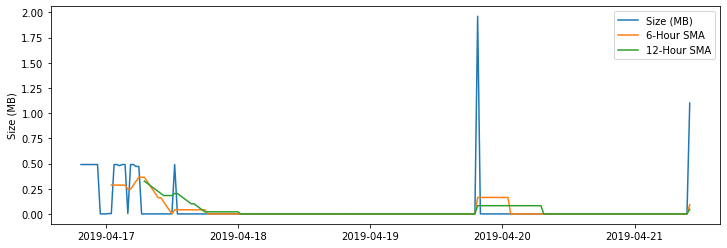

In [33]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df.index, 
        df,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

## Exponential Moving Average:

SMA time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units.

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

M = Number of time periods, span of the window
$t_{0}$ = Latest value
$t-1$ = Previous value
$EMA_{t-1}$ = Exponential moving average of previous day.
The multiplier: $\alpha = \frac{2}{M+1}$

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Example:

$EMA = (current day - EMA_{previous day}) * multiplier + EMA_{previous day}$
Initial SMA: 10-period sum / 10
Multiplier: (2 / (Time periods + 1) ) = (2 / (10 + 1) ) = 0.1818 (18.18%)

In [34]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = df.ewm(span=12, adjust=False).mean()
ema_short.tail()

2019-04-21 08:00:00+00:00    1.525388e-06
2019-04-21 08:30:00+00:00    1.290713e-06
2019-04-21 09:00:00+00:00    1.092142e-06
2019-04-21 09:30:00+00:00    9.241200e-07
2019-04-21 10:00:00+00:00    1.691687e-01
Freq: 30T, Name: size_mb, dtype: float64

In [35]:
span = 24
ema_long = df.ewm(span=span, adjust=False).mean()
ema_long.tail()

2019-04-21 08:00:00+00:00    0.000357
2019-04-21 08:30:00+00:00    0.000328
2019-04-21 09:00:00+00:00    0.000302
2019-04-21 09:30:00+00:00    0.000278
2019-04-21 10:00:00+00:00    0.088223
Freq: 30T, Name: size_mb, dtype: float64

### Comparing SMA and EMA:

Text(0, 0.5, 'Size (MB)')

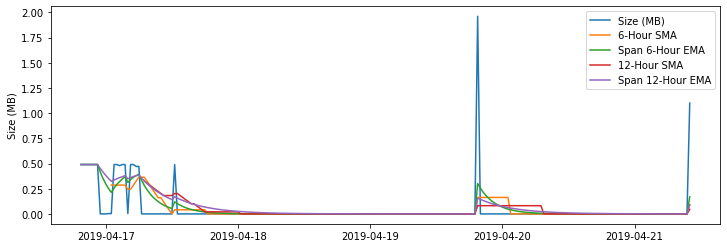

In [36]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df.index, 
        df,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

# Bollinger Bands, or %B:

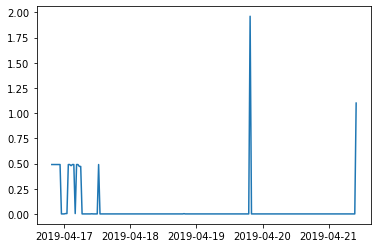

In [37]:
plt.plot(df)

## Steps to %B:

- compute rolling EMA...this will give us one for each timestamp from the first to $t_0$, the one before the target.

- compute rolling standard deviation

- compute upper band

- compute lower band

- compute percent b

To get the latest value:
**df[-1]**

In [38]:
# df is a dataframe with datetime as index and measure as the value. 

span = 24
ema = df.ewm(span=span, adjust=False).mean()
stdev = df.ewm(span=span, adjust=False).std()

# we want the following values to all be associated with the following target date/value, so we will compute them
# and then change to index to represent the following time period, essentially shifting each value down one 
# (or forward in terms of date). Basically, we will be comparing the value of one day to the ema computed through
# the previous day (and the ub and lb computed from that ema)...that way we are not using our the value from our 
# target date in the computation of the EMA we will compare that value to. 

ema = pd.DataFrame({'ema': ema})
stdev = pd.DataFrame({'stdev': stdev})
previous_val = pd.DataFrame({'previous_val': df})

prev_day_df = stdev.join(ema, how='left')
prev_day_df = prev_day_df.join(previous_val, how='left')

prev_day_df.fillna(0, inplace = True)

my_index = df.index[1:]
prev_day_df = prev_day_df[:-1].reset_index().set_index(my_index).drop(columns = ['index'])

target_val = pd.DataFrame({'target_val': df})

df = target_val.join(prev_day_df, how='left')
df.fillna(0, inplace = True)

# compute the upper and lower band
df['ub'] = df['ema'] + 3*df['stdev']
df['lb'] = df['ema'] - 3*df['stdev']

# compute percent b
df['pct_b'] = (df['target_val'] - df['lb']) / (df['ub'] - df['lb'])

In [41]:
print(df["pct_b"])

2019-04-16 19:30:00+00:00         inf
2019-04-16 20:00:00+00:00         NaN
2019-04-16 20:30:00+00:00         NaN
2019-04-16 21:00:00+00:00         NaN
2019-04-16 21:30:00+00:00         NaN
                               ...   
2019-04-21 08:00:00+00:00    0.497706
2019-04-21 08:30:00+00:00    0.497800
2019-04-21 09:00:00+00:00    0.497889
2019-04-21 09:30:00+00:00    0.497976
2019-04-21 10:00:00+00:00    8.187385
Freq: 30T, Name: pct_b, Length: 222, dtype: float64


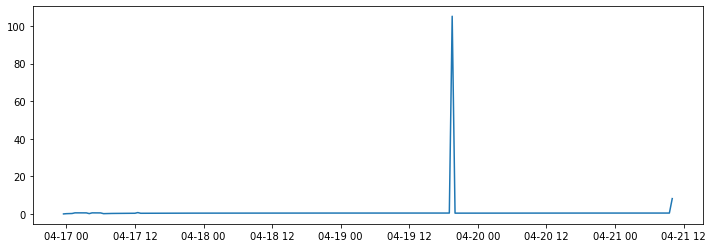

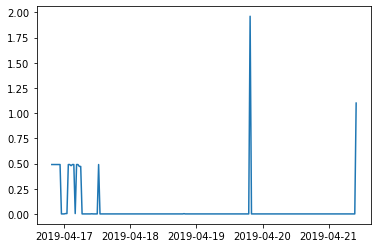

In [42]:
# plot
plt.figure(figsize=(12,4))
plt.plot(df.pct_b)
plt.show()
plt.plot(df.target_val)
plt.show()